### Colab Setup

In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/Time_series_ML"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root
  !pwd

  !pip install -r requirements.txt
  !sudo apt-get install nano
  !cp -f ./resources/cws.py /usr/local/lib/python3.8/dist-packages/scaleogram
  !sudo apt-get autoremove


  from IPython.display import JSON
  from google.colab import output
  from subprocess import getoutput
  import os
  
  #@title jQuery Terminal's [Features](https://terminal.jcubic.pl/)

  def shell(command):
    if command.startswith('cd'):
      path = command.strip().split(maxsplit=1)[1]
      os.chdir(path)
      return JSON([''])
    return JSON([getoutput(command)])
  output.register_callback('shell', shell) 

In [2]:
%reset -f
from IPython import get_ipython
get_ipython().magic('reset -sf') 
# import os
# os._exit(00)

/tmp/ipykernel_1299/319089568.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -sf')


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib
#plt.style.use('ggplot')
#matplotlib.use( 'tkagg' )
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from numpy import genfromtxt
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
import pylab as pl
import seaborn as sns
sns.set_style("ticks",{'axes.grid' : True})

from pathlib import Path
import shutil

2023-06-18 17:53:32.625461: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Import essential Tensorflow - Keras libraries

In [4]:
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model

try:
  IN_COLAB = True
  from google.colab import drive
  from tensorflow.keras.optimizers.legacy import RMSprop,Adam,SGD,Adadelta,Adagrad,Adamax
except:
  IN_COLAB = False
  from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adadelta,Adagrad,Adamax

from tensorflow.keras.optimizers.legacy import RMSprop,Adam,SGD,Adadelta,Adagrad,Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.keras.utils import plot_model, to_categorical, normalize
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [5]:
if IN_COLAB:
  DATA_FOLDER = 'Data/'
else:
  DATA_FOLDER = 'Data/'

HEATING_DATA = 'when2heat_DE.xlsx'
# WEATHER_DATA = 'DWD_4466_Schleswig.csv'


### Check for available GPUs and configure Tensorflow session to utilize GPU

In [6]:
import tensorflow as tf
try:
  # tf.debugging.experimental.enable_dump_debug_info('.', tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)
  # tf.debugging.set_log_device_placement(True)
  from tensorflow.python.client import device_lib

  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

  config = tf.compat.v1.ConfigProto()
  config.gpu_options.allow_growth = True
  config.gpu_options.per_process_gpu_memory_fraction = 0.1
  sess = tf.compat.v1.InteractiveSession(config=config)
  set_session(sess)
  print(device_lib.list_local_devices())
  gpus = tf.config.experimental.list_physical_devices('GPU')
  for gpu in gpus:
    try:
    
      tf.config.experimental.set_memory_growth(gpu, True)
      # Restrict TensorFlow to only use the first GPU
      tf.config.set_visible_devices(gpus[0], 'GPU')
      logical_gpus = tf.config.list_logical_devices('GPU')
      print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
      # Visible devices must be set before GPUs have been initialized
      print(e)

except Exception as error:
    print("Error trying to configure computing device.")
    print(error)

Found GPU at: /device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14408717290163415360
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4716494848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3088465049998817783
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]
1 Physical GPUs, 1 Logical GPU


2023-06-18 17:53:44.166822: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 17:53:44.939961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-18 17:53:45.005127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-18 17:53:45.006244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01

In [7]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13884565349441979916
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4716494848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7373943148343520650
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2023-06-18 17:53:45.729552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-18 17:53:45.730798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-18 17:53:45.731718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-18 17:53:45.732925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-18 17:53:45.732990: I tensorflow/core/co

### Version Check: Tensorflow - Cuda - CuDNN 

In [8]:
from tensorflow.python.platform import build_info as tf_build_info
print("Tensorflow verison: ",tf.__version__)


Tensorflow verison:  2.11.0


### Setup Tensorflow-GPU precision 
Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory. 

In [9]:
# tf.keras.backend.floatx()
# tf.keras.backend.set_floatx('float16')
# tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
tf.keras.backend.floatx()

'float32'

### Import CSV Data with Pandas

,count,mean,std,min,25%,50%,75%,max
Total_Heat,61368.0,0.238653,0.188105,0.0,0.070517,0.193646,0.375777,1.0
Hour,61368.0,0.500000,0.300967,0.0,0.250000,0.500000,0.750000,1.0
Day,61368.0,0.491031,0.293357,0.0,0.233333,0.500000,0.733333,1.0
Month,61368.0,0.502044,0.313532,0.0,0.272727,0.545455,0.818182,1.0
Year,61368.0,0.499870,0.333369,0.0,0.166667,0.500000,0.833333,1.0
Weekday,61368.0,0.499804,0.333287,0.0,0.166667,0.500000,0.833333,1.0
Weekend,61368.0,0.261700,0.416401,0.0,0.000000,0.000000,0.833333,1.0
Holiday,61368.0,0.024247,0.153817,0.0,0.000000,0.000000,0.000000,1.0


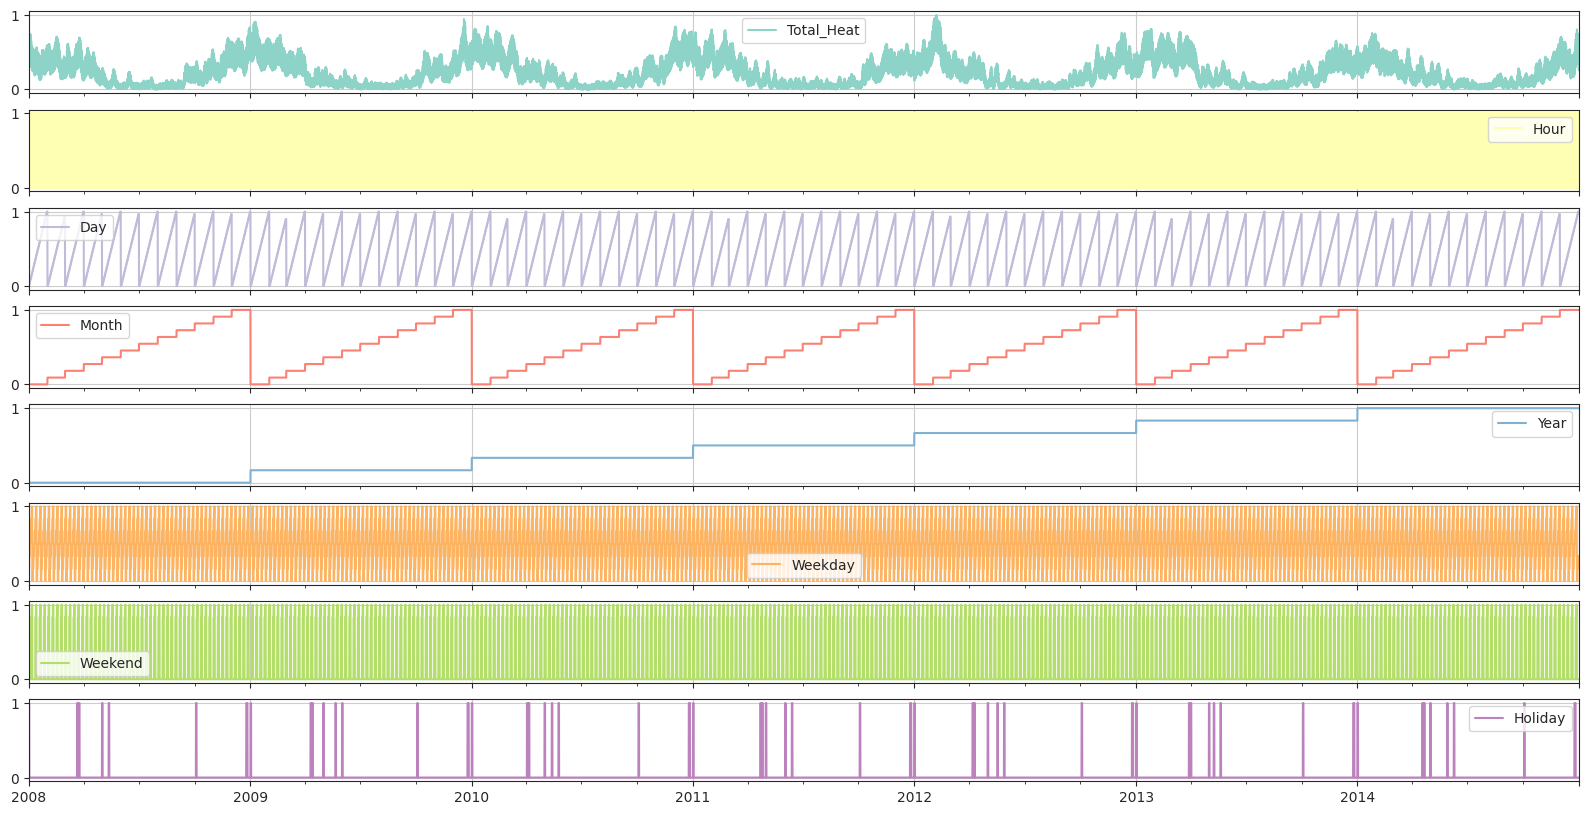

In [10]:
if IN_COLAB:
  DATA_FOLDER = './data/'
else:
  DATA_FOLDER = './../data/'

HEATING_DATA = 'when2heat_DE.xlsx'
# WEATHER_DATA = 'DWD_4466_Schleswig.csv'


myData = pd.read_csv(os.path.join(DATA_FOLDER, 'Dataset_Prep.csv'))
timestamps = pd.to_datetime(myData.iloc[:,0].values)
myData = myData.set_index(timestamps).asfreq(freq='h').drop(myData.columns[0], axis=1)
myData = pd.DataFrame(MinMaxScaler().fit_transform(myData.values), columns=myData.columns).set_index(timestamps).asfreq(freq='h')

myData.describe().transpose()
myData.plot(subplots=True, figsize=(20,10))
myData.tail(20)
# myData.set_index(pd.to_datetime(myData['Date'])).asfreq(freq='D')
# myData.round(decimals=6)
# myData=myData.astype(np.float32)
# myData=myData.astype(np.float16)
myData.describe().transpose()


### Check Datatypes

In [11]:
# myData.convert_dtypes('float16')
myData.dtypes

Total_Heat    float64
Hour          float64
Day           float64
Month         float64
Year          float64
Weekday       float64
Weekend       float64
Holiday       float64
dtype: object

### Check Shape of DataFrame

In [12]:
myData.shape

(61368, 8)

### List of features or signals used in the data-set.

In [13]:
data_top = myData.columns.values
data_top

array(['Total_Heat', 'Hour', 'Day', 'Month', 'Year', 'Weekday', 'Weekend',
       'Holiday'], dtype=object)

### Display top rows of the DataFrame

In [14]:
myData.head()

,Total_Heat,Hour,Day,Month,Year,Weekday,Weekend,Holiday
2008-01-01 00:00:00+00:00,0.362881,0.000000,0.0,0.0,0.0,0.166667,0.0,1.0
2008-01-01 01:00:00+00:00,0.371961,0.043478,0.0,0.0,0.0,0.166667,0.0,1.0
2008-01-01 02:00:00+00:00,0.397763,0.086957,0.0,0.0,0.0,0.166667,0.0,1.0
2008-01-01 03:00:00+00:00,0.449547,0.130435,0.0,0.0,0.0,0.166667,0.0,1.0
2008-01-01 04:00:00+00:00,0.594798,0.173913,0.0,0.0,0.0,0.166667,0.0,1.0


### Display bottom rows of the DataFrame

In [15]:
myData.tail()

,Total_Heat,Hour,Day,Month,Year,Weekday,Weekend,Holiday
2014-12-31 19:00:00+00:00,0.576926,0.826087,1.0,1.0,1.0,0.333333,0.0,0.0
2014-12-31 20:00:00+00:00,0.521848,0.869565,1.0,1.0,1.0,0.333333,0.0,0.0
2014-12-31 21:00:00+00:00,0.424086,0.913043,1.0,1.0,1.0,0.333333,0.0,0.0
2014-12-31 22:00:00+00:00,0.261670,0.956522,1.0,1.0,1.0,0.333333,0.0,0.0
2014-12-31 23:00:00+00:00,0.261670,1.000000,1.0,1.0,1.0,0.333333,0.0,0.0


### Check for Missing Data 


In [16]:
myData.isnull().values.any()

False

### Plot a few signals 


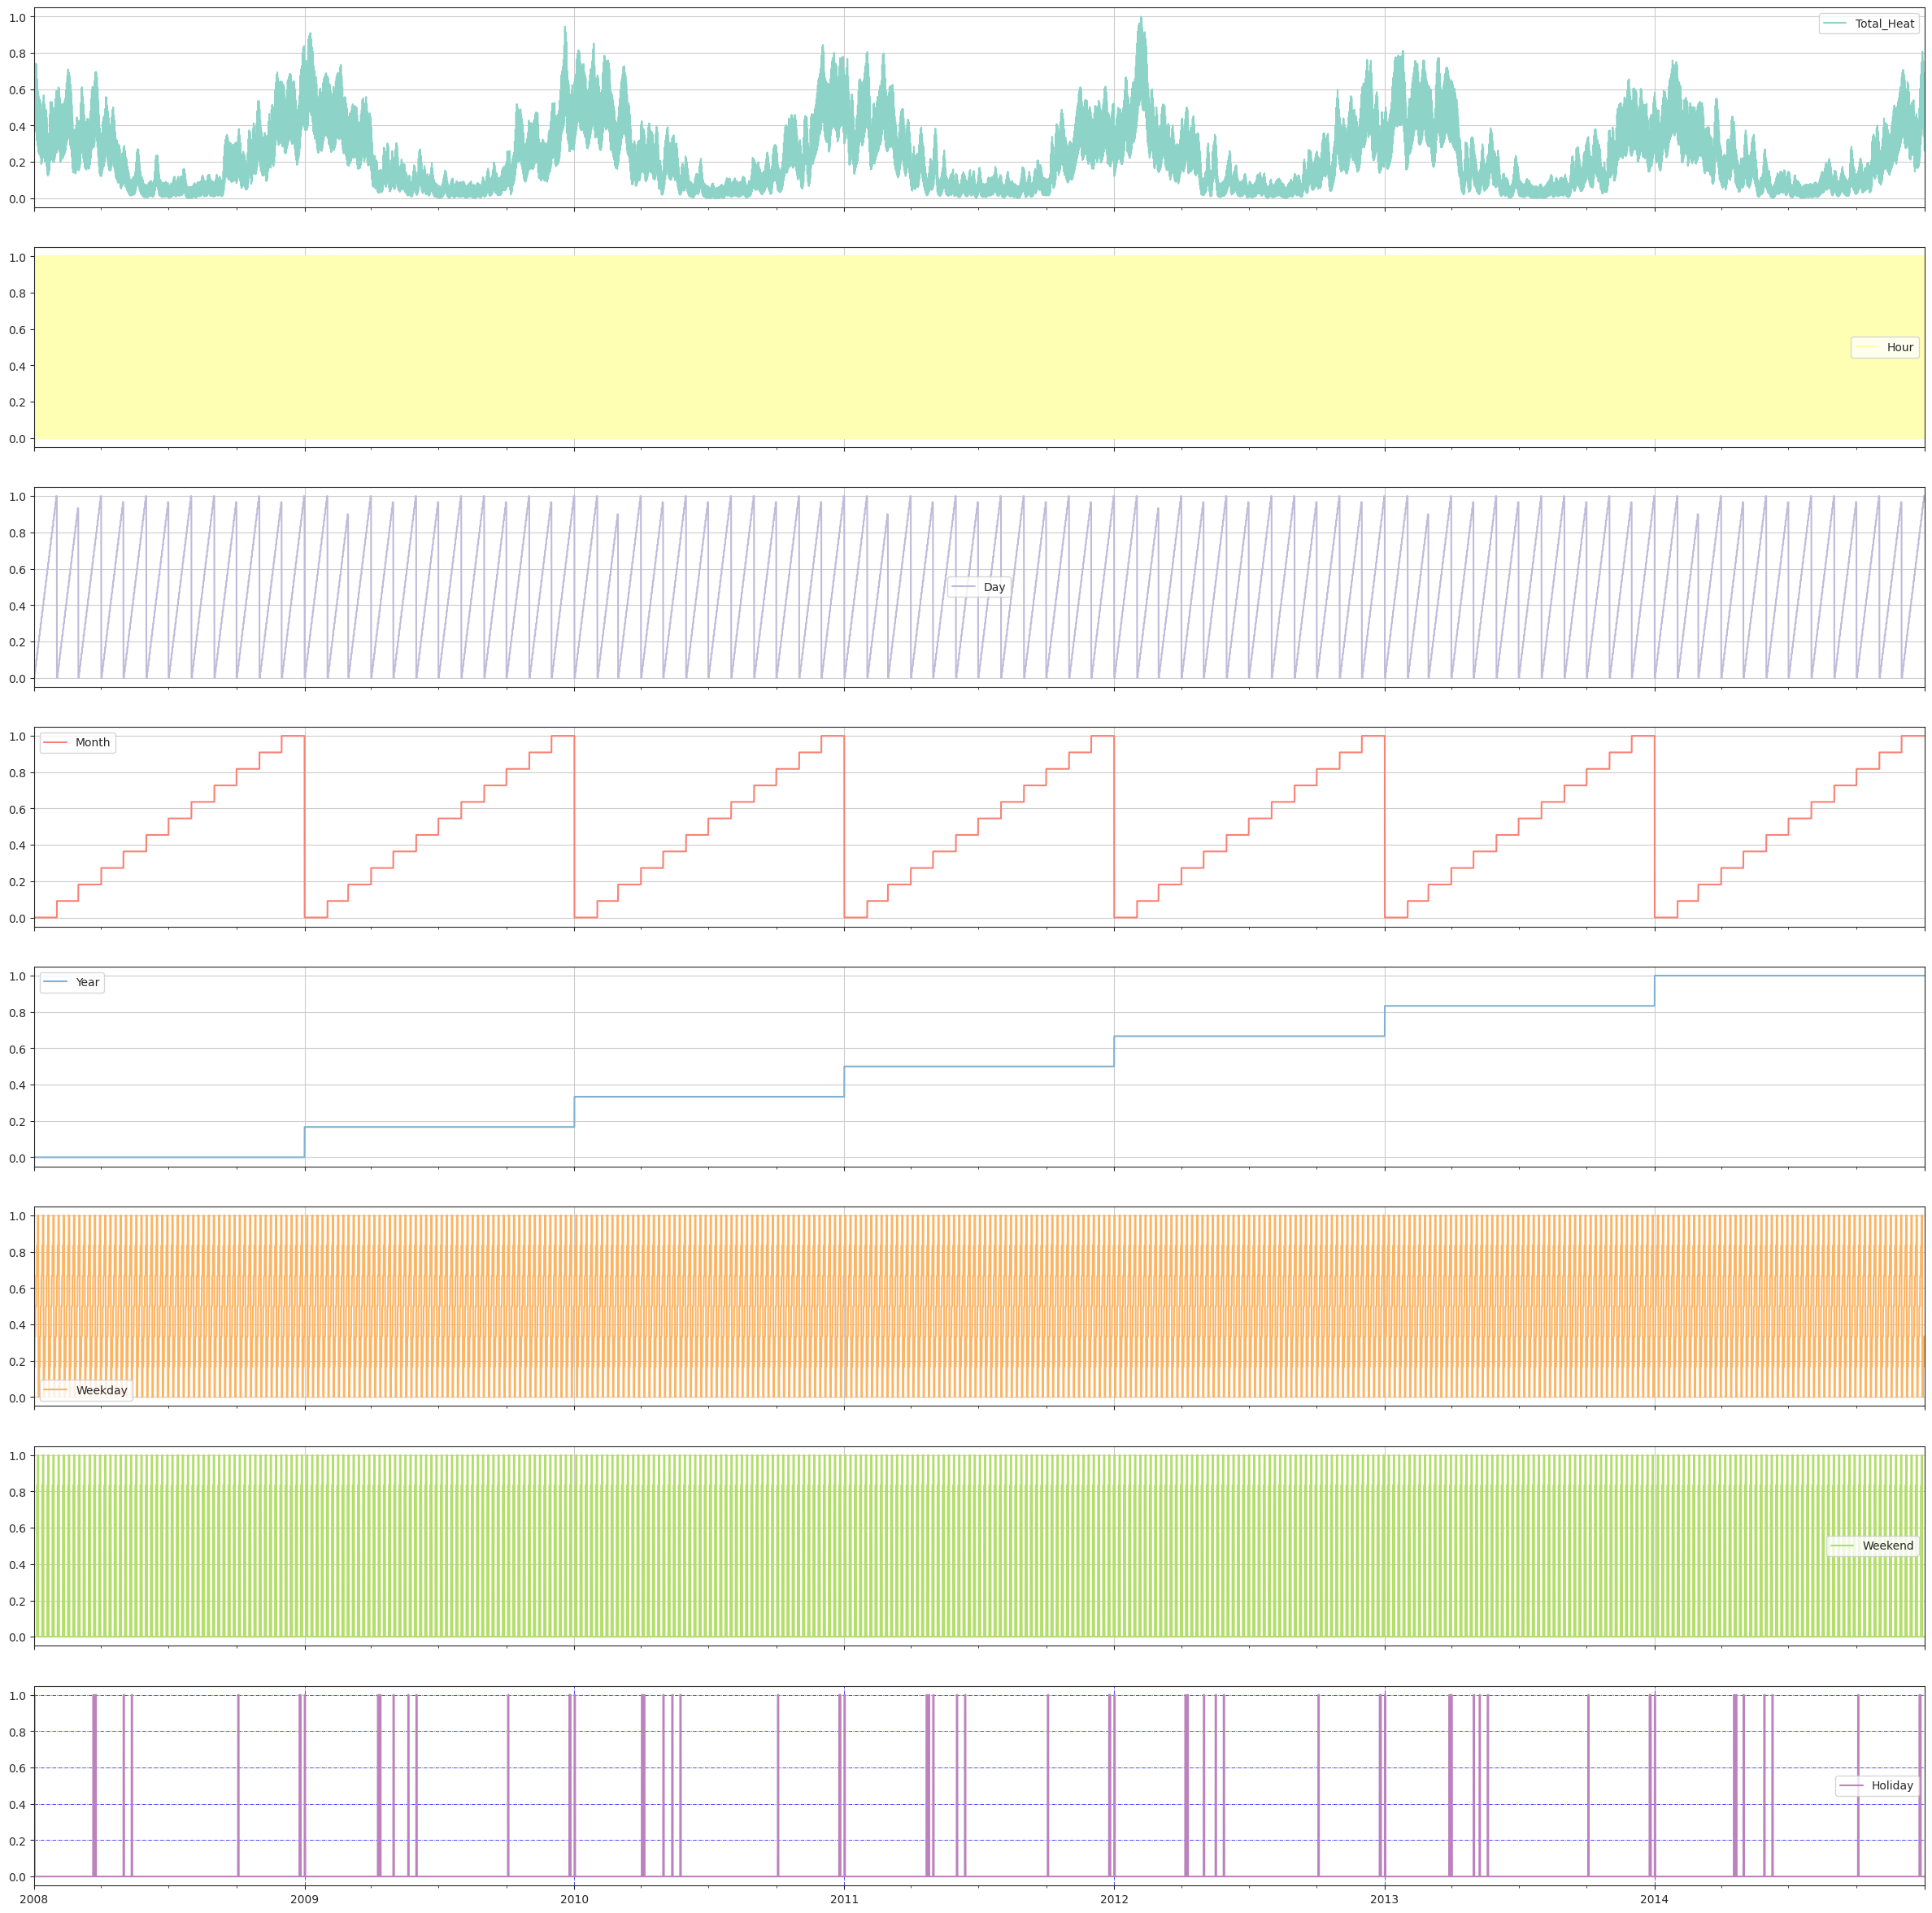

In [17]:
myData.plot(subplots=True, figsize=(30,30), sharex=True)
plt.grid(color='b', linestyle='-.', linewidth=0.5)
plt.show()

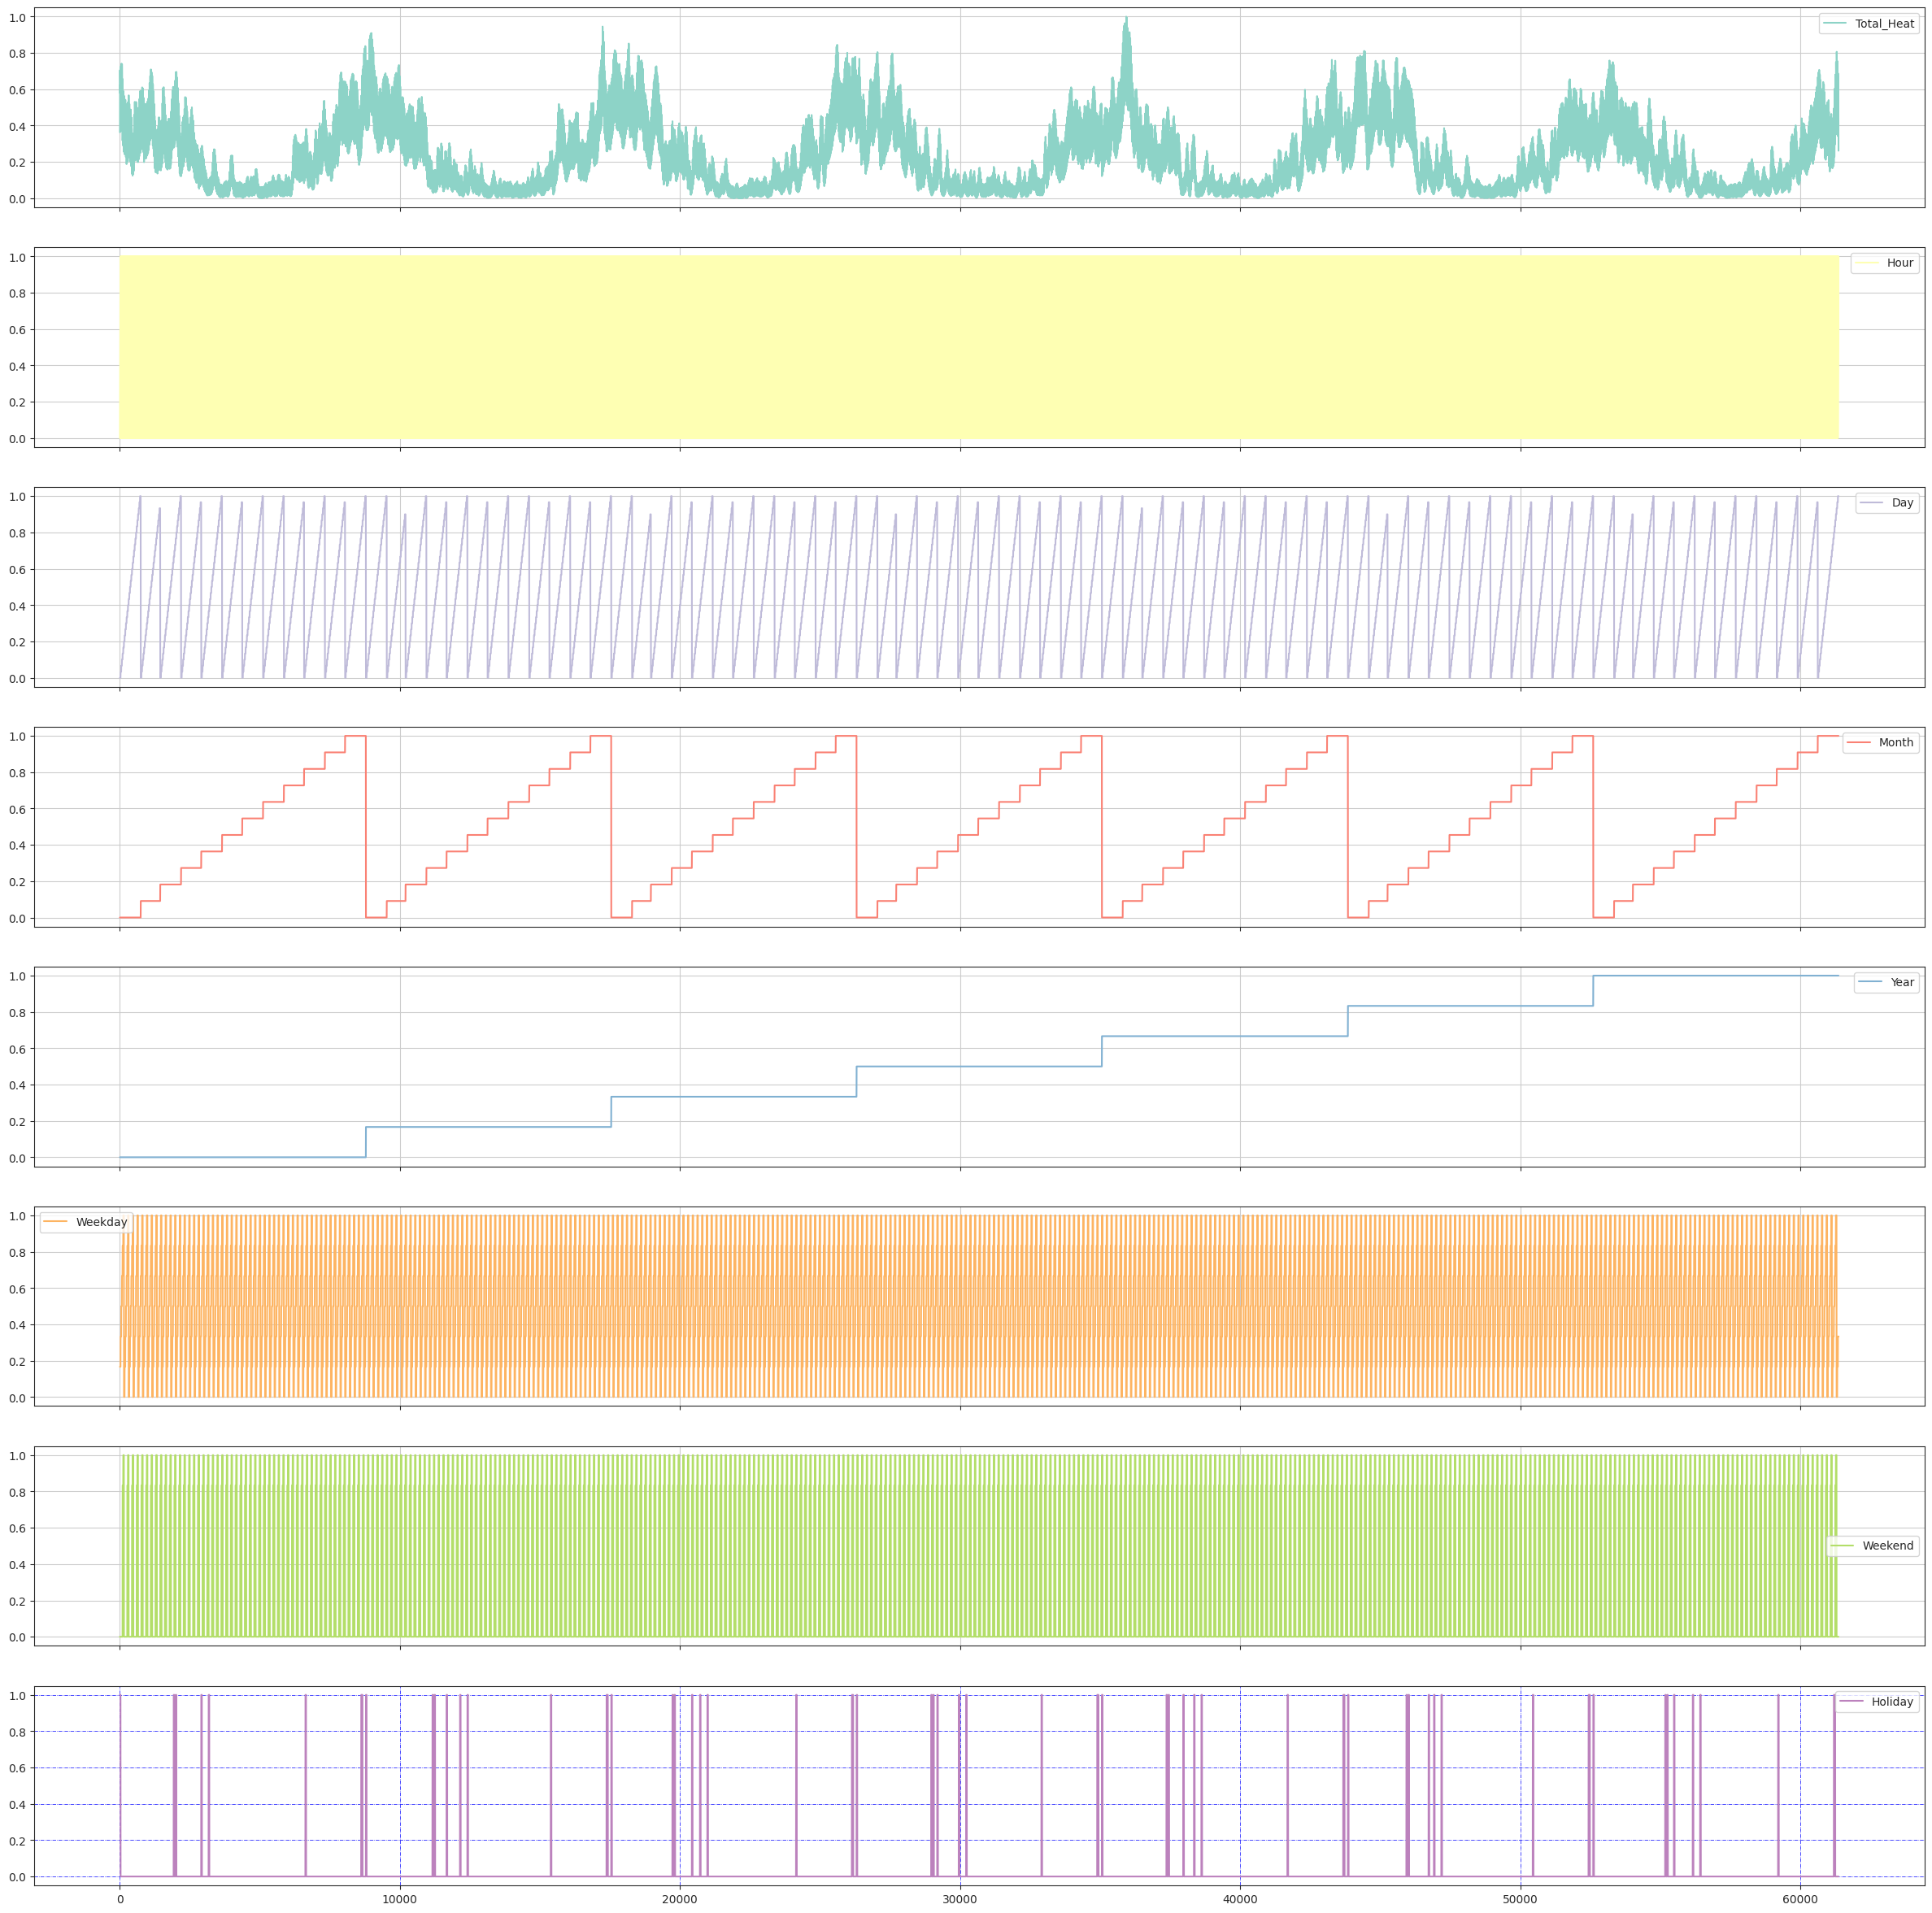

In [18]:
df_scaler = MinMaxScaler()
pd.DataFrame(df_scaler.fit_transform(myData.values), columns=myData.columns).plot(subplots=True, figsize=(30,30), sharex=True)
plt.grid(color='b', linestyle='-.', linewidth=0.5)
plt.show()

### Input - Output Feature Selection

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

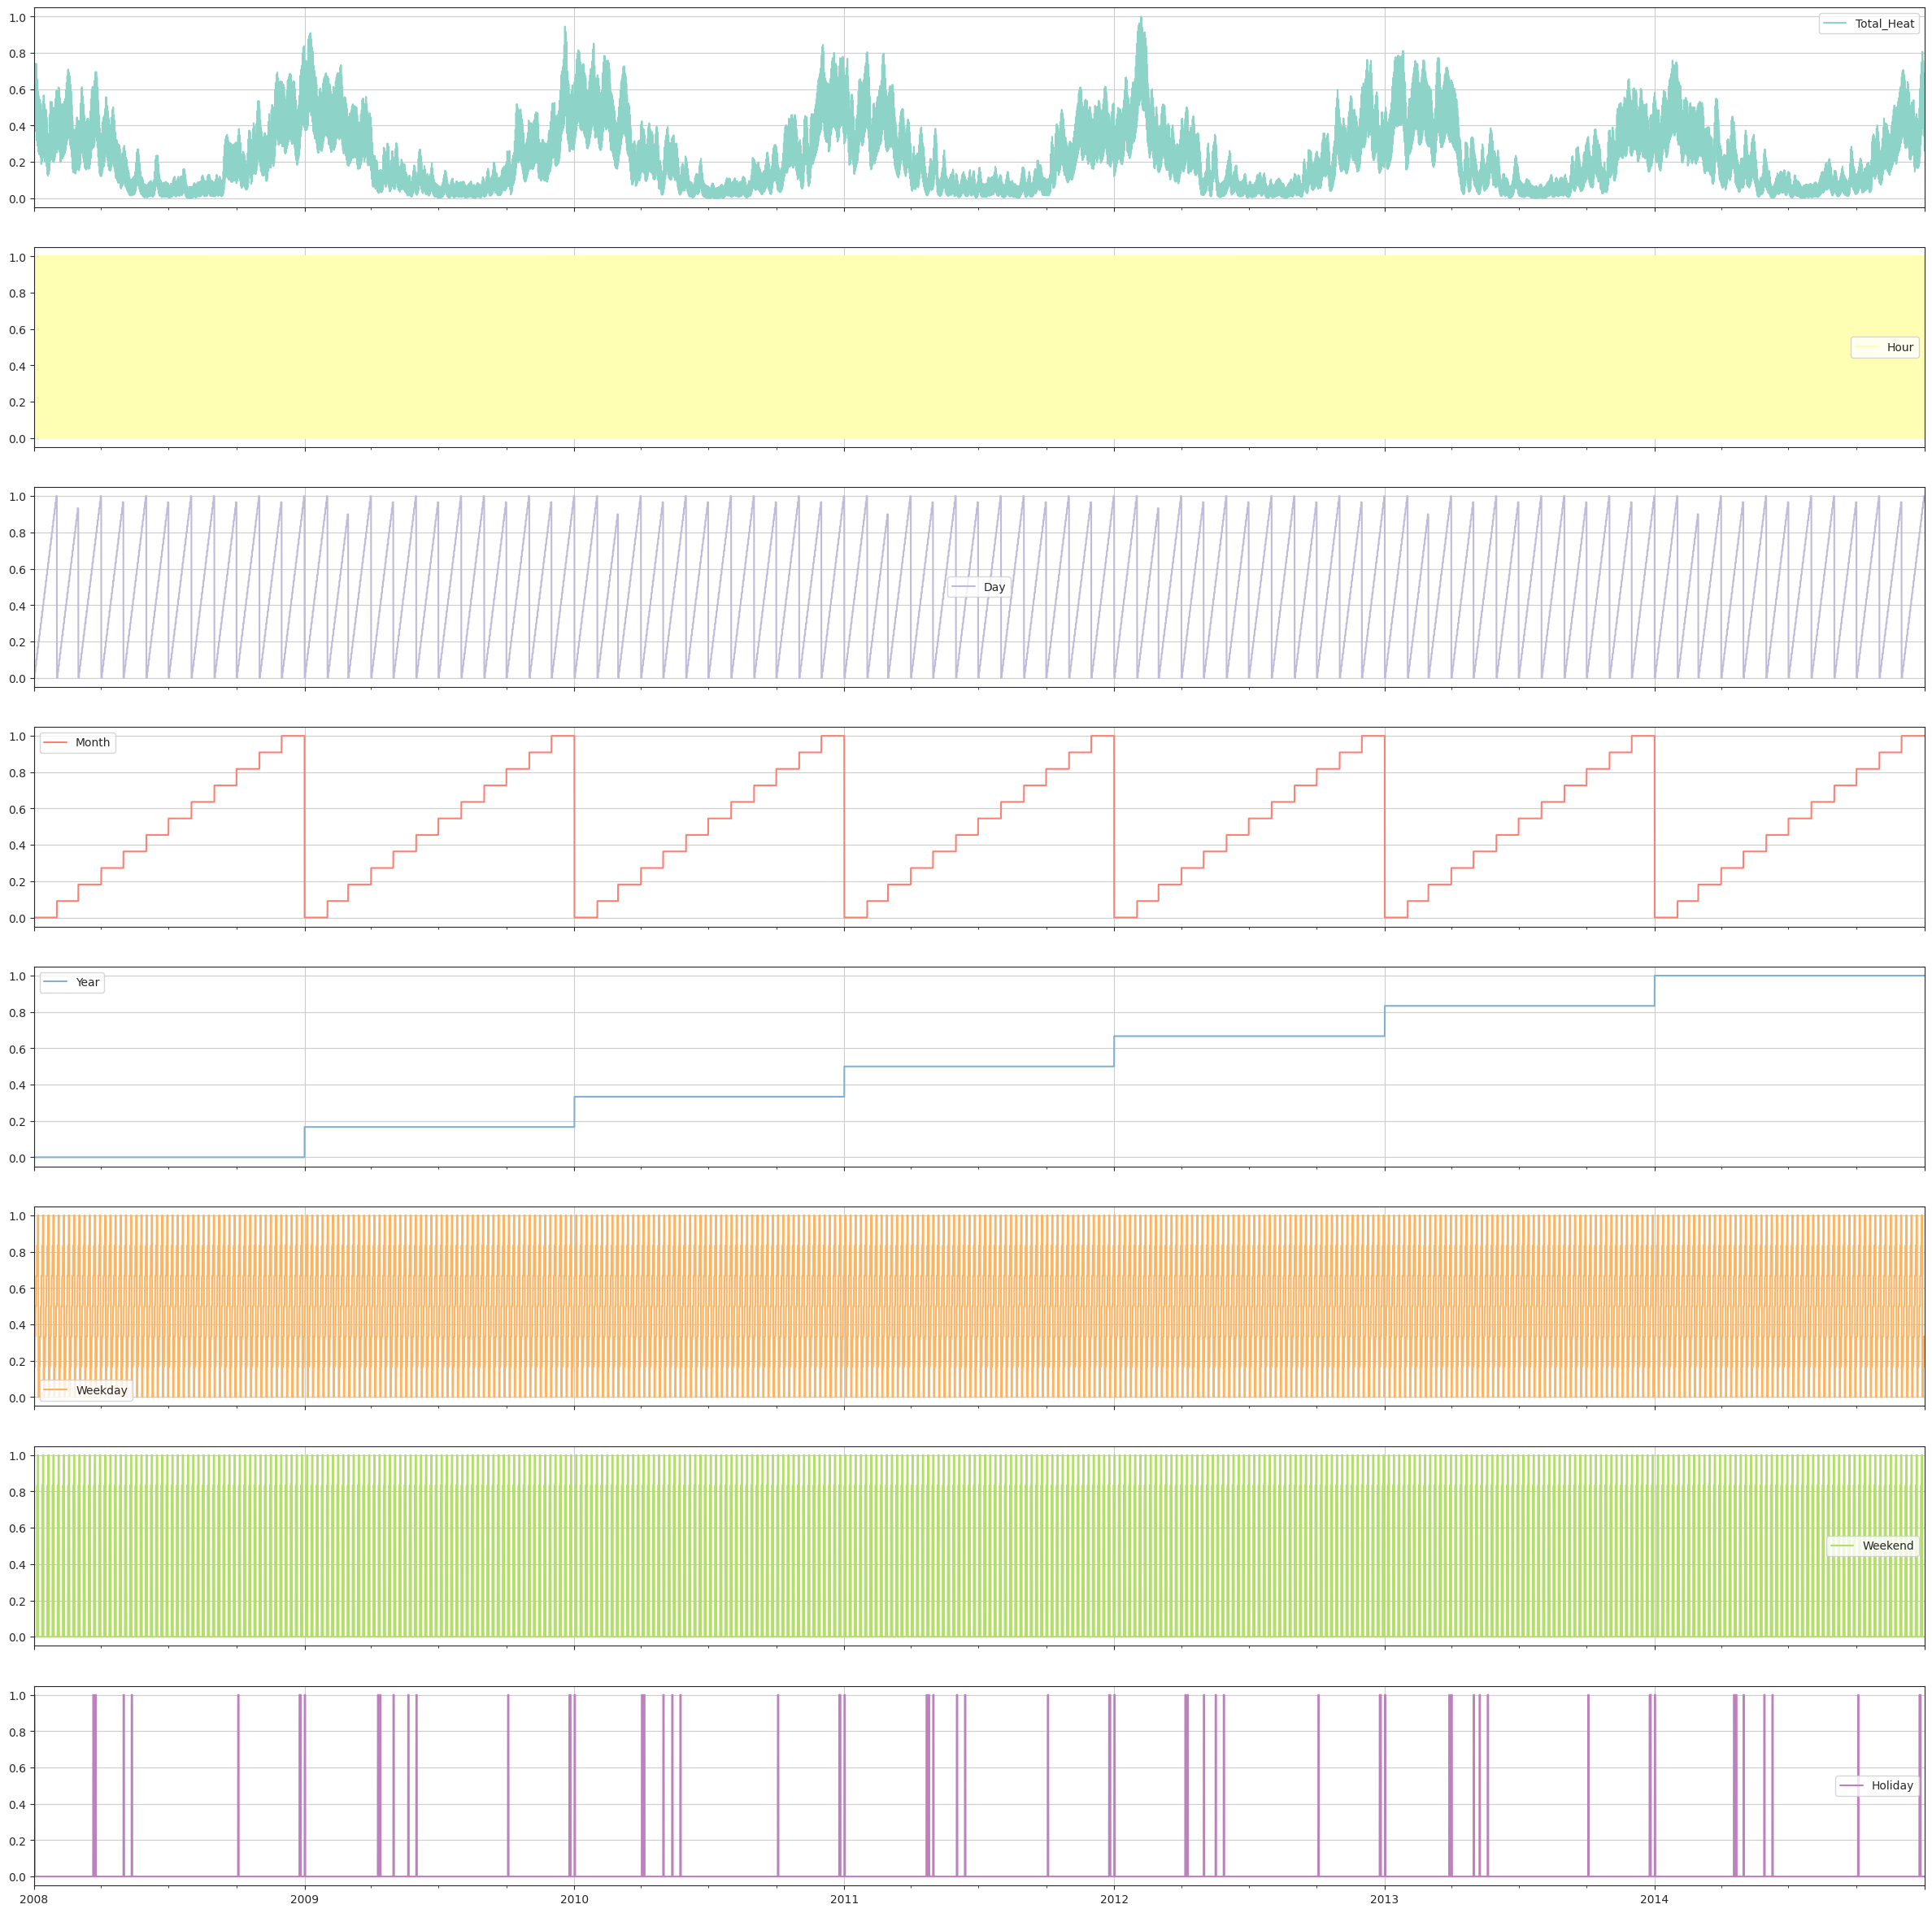

In [19]:
myData.plot(subplots=True, figsize=(30,30), sharex=True)

In [20]:
myData.columns.values

array(['Total_Heat', 'Hour', 'Day', 'Month', 'Year', 'Weekday', 'Weekend',
       'Holiday'], dtype=object)

In [21]:
input_names = ['Total_Heat'] #  'Hour', 'Day', 'Month', 'Year', 'Weekday', 'Weekend', 'Holiday'
 
target_names = ['Total_Heat']

### Attempting to Predict the future Target Features.

#### To achieve this we shift the target features by one timestep backward

In [22]:
forecast_horizon = 48

In [23]:
def create_X_y(data_df: pd.DataFrame, train_days:int, forecast_days:int):
    """"""
    X_list = []
    y_list = []

    for i in range(train_days*24, len(data_df)-forecast_days*24, 24):
        X_list.append(data_df.iloc[i-train_days*24:i])
        y_list.append(data_df[i:i+forecast_days*24])
    
    return X_list, y_list

def create_X_y(data_array: np.array, train_days:int, forecast_days:int):
    """"""
    X_list = []
    y_list = []

    for i in range(train_days*24, len(data_array)-forecast_days*24, 24):
        X_list.append(data_array[i-train_days*24:i])
        y_list.append(data_array[i:i+forecast_days*24])
    
    return X_list, y_list

x_train, y_train = create_X_y(myData[:'31-12-2013'][input_names].values.astype(np.float32, casting='unsafe'), 14, 2)
x_test, y_test = create_X_y(myData['01-01-2014':'31-12-2014'][input_names].values.astype(np.float32, casting='unsafe'), 14, 2)

/tmp/ipykernel_1299/2484773523.py:23: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  x_train, y_train = create_X_y(myData[:'31-12-2013'][input_names].values.astype(np.float32, casting='unsafe'), 14, 2)
/tmp/ipykernel_1299/2484773523.py:24: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  x_test, y_test = create_X_y(myData['01-01-2014':'31-12-2014'][input_names].values.astype(np.float32, casting='unsafe'), 14, 2)


### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has `NaN` for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

These are the input-signals:

### Define training, validation and testing sample size

In [24]:
shuffle = False
BATCH_SIZE = 32
sequence_length = 24*14
sequence_length

336

In [25]:
# y_scaler = QuantileTransformer()
# x_scaler = QuantileTransformer()
# x_data = x_scaler.fit_transform(x_data)
# y_data = y_scaler.fit_transform(y_data)

In [26]:
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=train_split, random_state=None, shuffle=shuffle)
# x_train, x_test, y_train, y_test = x_data[:500],x_data[500:1000],y_data[:500],y_data[500:1000]

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (2176, 336, 1)
y_train shape: (2176, 48, 1)
x_test shape: (349, 336, 1)
y_test shape: (349, 48, 1)


This is the number of observations in the training-set:

In [27]:
num_train = len(x_train)
num_train

2176

This is the number of observations in the test-set:

In [28]:
num_test = len(x_test)
num_test

349

These is the total number of input observations for the training and test sets:

In [29]:
len(x_train) + len(x_test)

2525

These is the total number of output observations for the training and test sets:

In [30]:
len(y_train) + len(y_test)

2525

This is the number of input features:

In [31]:
num_x_signals = x_train.shape[-1]
num_x_signals

1

This is the number of target features:

In [32]:
num_y_signals = x_train.shape[-1]
num_y_signals

1

### Check Data Magnitudes

The data-set contains a wide range of values:

In [33]:
print('x_train min:', x_train.min())
print('x_train max:', x_train.max())

print('y_train min:', y_train.min())
print('y_train max:', y_train.max())

print('x_test min:', x_test.min())
print('x_test max:', x_test.max())

print('y_test min:', y_test.min())
print('y_test max:', y_test.max())

x_train min: 0.0
x_train max: 1.0
y_train min: 0.0
y_train max: 1.0
x_test min: 0.0014724152
x_test max: 0.7585009
y_test min: 0.0014724152
y_test max: 0.80640423



## Check Train and Test Set Distribution


In [34]:
y_train.shape

(2176, 48, 1)

<AxesSubplot: ylabel='Density'>

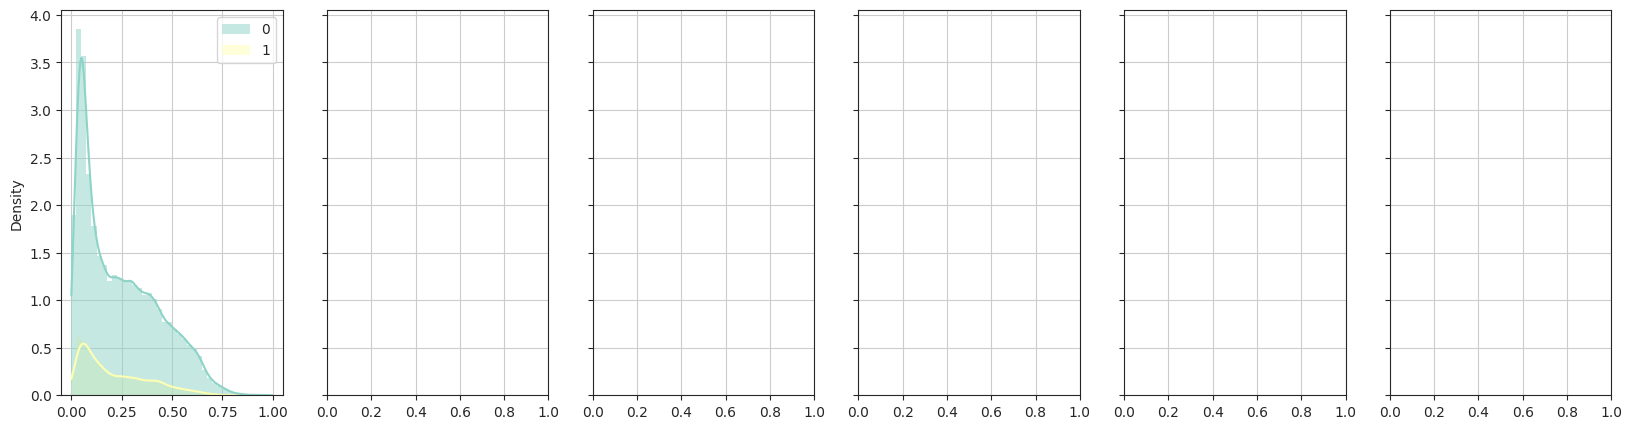

In [35]:
fig, axes = plt.subplots(1, 6, figsize=(20, 5), sharey=True)
sns.histplot([y_train[...,0].flatten(),y_test[...,0].flatten()], ax=axes[0], bins=40, kde=True, stat="density", linewidth=0, edgecolor='black')
# sns.histplot([y_train[:,1],y_test[:,1]], ax=axes[1], bins=40, kde=True, stat="density", linewidth=0, edgecolor='black')
# sns.histplot([y_train[:,2],y_test[:,2]], ax=axes[2], bins=40, kde=True, stat="density", linewidth=0, edgecolor='black')
# sns.histplot([y_train[:,3],y_test[:,3]], ax=axes[3], bins=40, kde=True, stat="density", linewidth=0, edgecolor='black')
# sns.histplot([y_train[:,4],y_test[:,4]], ax=axes[4], bins=40, kde=True, stat="density", linewidth=0, edgecolor='black')
# sns.histplot([y_train[:,5],y_test[:,5]], ax=axes[5], bins=40, kde=True, stat="density", linewidth=0, edgecolor='black')


## Custom Tensorflow Data Generator 

The data-set has now been prepared as 2-dimensional numpy arrays. 

These are the array-shapes of the input and output data:

In [36]:
# Create the initial dataset.
dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train,),
                                    tf.data.Dataset.from_tensor_slices(y_train)))
# val_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_test,),
#                                     tf.data.Dataset.from_tensor_slices(Y_test)))



# Shuffle the dataset.
# dataset = dataset.shuffle(buffer_size=len(data[0]))

# Determine the size of the dataset
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

# Define the split sizes (e.g., 80% training, 20% validation)
train_size = int(0.1 * dataset_size)
val_size = dataset_size - train_size

# Split the dataset into training and validation sets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Determine the size of the dataset
train_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_size = tf.data.experimental.cardinality(val_dataset).numpy()

# Shuffle the dataset.
# train_dataset = train_dataset.shuffle(buffer_size=train_size)
# val_dataset = val_dataset.shuffle(buffer_size=val_size)

# Apply the map transformation with the data preparation function.
# train_dataset = train_dataset.map(tf_prepare_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# val_dataset = val_dataset.map(tf_prepare_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Use 'cache' after 'map' to cache processed data, use 'repeat' to repeat the dataset indefinitely.
train_dataset = train_dataset.cache()
val_dataset = val_dataset.cache()

# Batch the training and validation datasets.
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Prefetch the training and validation datasets.
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the shape of the first batch from both datasets.
inp_train, outp_train = next(iter(train_dataset))
inp_val, outp_val = next(iter(val_dataset))


try:
    print("Training dataset shapes:", inp_train.shape, outp_train.shape)
except:
  pass





Training dataset shapes: (32, 336, 1) (32, 48, 1)


2023-06-18 17:54:40.606090: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-06-18 17:54:40.618632: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Build and Compile the Sales Prediction Model

In [39]:
def create_LSTM_model(N=1):
    inputs = layers.Input(name='Input_Layer', shape=(None, num_x_signals))
    
    # Extract Features
    Out1 = LSTM(name='H1', units=8, return_sequences=False, trainable=True)(inputs)
    
    # Predict output from features
    rescaled_out = Dense(num_y_signals*forecast_horizon*2, name='FC_Layer0', activation='gelu', use_bias=True)(Out1)
    rescaled_out = Dense(num_y_signals*forecast_horizon, name='FC_Layer', activation='gelu', use_bias=True)(rescaled_out)
    outputs = Reshape(name='Output_Layer', target_shape=(forecast_horizon, num_y_signals))(rescaled_out)
        
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs, name='LSTM_Heat_model')

    return model


In [42]:
MODEL, Heat_model = 'LSTM', create_LSTM_model()

# Create Optimizer.
# Define the parameters for the schedule
initial_learning_rate = 1e-3
decay_steps = 4000
first_decay_steps = 8000

# Create the schedule
optimizer = Adam(learning_rate=initial_learning_rate, amsgrad=True)
moving_avg_Adam = tfa.optimizers.MovingAverage(optimizer)
stocastic_avg_Adam = tfa.optimizers.SWA(optimizer)

Heat_model.compile(loss=MeanExponentWeightedError(), optimizer=stocastic_avg_Adam, metrics=['mse', 'mae', 'mape'], run_eagerly=True)

with tf.device('/device:GPU:0'):
  # _ = Heat_model.evaluate(train_dataset, steps=2, verbose=2)
  #_ = Heat_model.fit(x_train_generator, epochs=2, verbose=2)
  pass
Heat_model.summary()

Model: "LSTM_Heat_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, None, 1)]         0         
                                                                 
 H1 (LSTM)                   (None, 8)                 320       
                                                                 
 FC_Layer0 (Dense)           (None, 96)                864       
                                                                 
 FC_Layer (Dense)            (None, 48)                4656      
                                                                 
 Output_Layer (Reshape)      (None, 48, 1)             0         
                                                                 
Total params: 5,840
Trainable params: 5,840
Non-trainable params: 0
_________________________________________________________________


# Plot Heat model

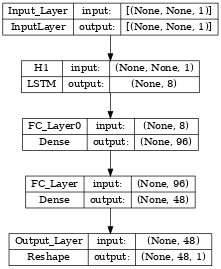

In [60]:
plot_model(Heat_model, show_shapes=True, to_file=os.path.join(DATA_FOLDER, f'model/{MODEL}_Heat_model.png'), show_layer_names=True, rankdir='TB', expand_nested=True, dpi=50)


## Implement Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.
This is the callback for writing checkpoints during training.

In [44]:
from tensorflow.python.framework.test_util import run_functions_eagerly
save_format = 'h5'
path_checkpoint = os.path.join(DATA_FOLDER, f'model/{MODEL}_Heat_model.{save_format}')
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_mse',
                                      verbose=1,
                                      save_weights_only=True,
                                      restore_best_weights=True,
                                      save_best_only=True, 
                                      run_functions_eagerly=True,
                                      save_format=save_format)

path_checkpoint_MA = os.path.join(DATA_FOLDER, f'model/{MODEL}_Heat_model_MA.{save_format}')

path_checkpoint_SWA = os.path.join(DATA_FOLDER, f'model/{MODEL}_Heat_model_SWA.{save_format}')

callback_MA = tfa.callbacks.AverageModelCheckpoint(filepath=path_checkpoint_MA, 
                                                    monitor='val_mse',
                                                    update_weights=True,
                                                    save_weights_only=True,
                                                    run_functions_eagerly=True, 
                                                    save_format=save_format)

callback_SWA = tfa.callbacks.AverageModelCheckpoint(filepath=path_checkpoint_SWA,
                                                    monitor='val_mse',
                                                    update_weights=True,
                                                    save_weights_only=True,
                                                    run_functions_eagerly=True,
                                                    save_format=save_format)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [45]:
callback_early_stopping = EarlyStopping(  monitor="val_mse",
                                          # min_delta=0,
                                          patience=100,
                                          verbose=1,
                                          mode="auto",
                                          # baseline=None,
                                          restore_best_weights=True )

This is the callback for writing the TensorBoard log during training.

In [61]:
import datetime
# dirpaths = [Path(os.path.join(DATA_FOLDER, r'model//TensorBoard/'))]

# for dirpath in dirpaths:
#     if dirpath.exists() and dirpath.is_dir():
#         try:        
#             shutil.rmtree(dirpath, ignore_errors=True)
#             os.chmod(dirpath, 0o777)
#             os.rmdir(dirpath)
#             os.removedirs(dirpath)
#             print("Directory '%s' has been removed successfully", dirpath)
#         except OSError as error:
#             print(error)
#             print("Directory '%s' can not be removed", dirpath)

logdir = os.path.join(DATA_FOLDER, r'model//TensorBoard/')
logdir = os.path.join(logdir, r'RUN' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callback_tensorboard = TensorBoard(log_dir=logdir,
                                   histogram_freq=1,
                                   write_graph=True,
                                   profile_batch = False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=100`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-2 above, so multiplying it by 0.95 gives a learning-rate of 9.5e-3. We don't want the learning-rate to go any lower 1e-5

In [62]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_mse',
                                       factor=0.99,
                                       min_lr=1e-5,
                                       patience=5,
                                       verbose=1)    



In [63]:
from collections.abc import Iterable
from tensorflow.keras.callbacks import *
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.framework import constant_op
import math


class CosineDecayRestarts(tf.keras.callbacks.Callback):
    def __init__(self, initial_learning_rate, first_decay_steps, alpha=0.0, t_mul=2.0, m_mul=1.0):
        super(CosineDecayRestarts, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.first_decay_steps = first_decay_steps
        self.alpha = alpha
        self.t_mul = t_mul
        self.m_mul = m_mul
        self.batch_step = 0

    def on_train_batch_begin(self, step, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(self.batch_step, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        self.batch_step += 1

    def schedule(self, step, lr):
        def compute_step(completed_fraction, geometric=False):
            """Helper for `cond` operation."""
            if geometric:
                i_restart = math_ops.floor(
                  math_ops.log(1.0 - completed_fraction * (1.0 - self.t_mul)) /
                  math_ops.log(self.t_mul))

                sum_r = (1.0 - self.t_mul**i_restart) / (1.0 - self.t_mul)
                completed_fraction = (completed_fraction - sum_r) / self.t_mul**i_restart

            else:
                i_restart = math_ops.floor(completed_fraction)
                completed_fraction -= i_restart

            return i_restart, completed_fraction

        completed_fraction = step / self.first_decay_steps

        i_restart, completed_fraction = control_flow_ops.cond(
          math_ops.equal(self.t_mul, 1.0),
          lambda: compute_step(completed_fraction, geometric=False),
          lambda: compute_step(completed_fraction, geometric=True))

        m_fac = self.m_mul**i_restart
        cosine_decayed = 0.5 * m_fac * (1.0 + math_ops.cos(
          constant_op.constant(math.pi) * completed_fraction))
        decayed = (1 - self.alpha) * cosine_decayed + self.alpha

        return math_ops.multiply(self.initial_learning_rate, decayed)

callback_cosine_decay_restarts = CosineDecayRestarts( initial_learning_rate,
                                                      first_decay_steps)

In [72]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_cosine_decay_restarts,
             callback_SWA,
             callback_reduce_lr]

#### Load weights from last checkpoint

In [73]:
def train_model(resume, epochs, initial_epoch, batch_size, model, savepath):

    print(model.summary())
    history=model.fit(train_dataset, 
                        # steps_per_epoch=steps_per_epoch, 
                        epochs=EPOCHS, 
                        verbose=1, 
                        callbacks=callbacks,
                        validation_data=val_dataset, 
                        # validation_steps=train_validation_steps, 
                        #validation_freq=5,
                        #class_weight=None, 
                        #max_queue_size=10, 
                        #workers=8, 
                        #use_multiprocessing=True,
                        #shuffle=True, 
                        initial_epoch=initial_epoch)
    
    model.load_weights(savepath)
    print("Checkpoint Loaded")  
    model.evaluate(x_test_generator, steps=test_validation_steps)

    if resume:
        try:
            #del model
            model.load_weights(savepath, {"MeanExponentWeightedError":MeanExponentWeightedError})
            #model = load_model(savepath, {"MeanExponentWeightedError":MeanExponentWeightedError})
            print("Checkpoint Loaded")  
        except Exception as error:
            print("Error trying to load checkpoint.")
            print(error)

    return history, model

def plot_train_history(history, title):
        loss = history.history['loss']
        accuracy = history.history['acc']
        mape = history.history['mape']
        mae = history.history['mae']
        val_loss = history.history['val_loss']
        val_accuracy = history.history['val_acc']
        val_mae = history.history['val_mae']
        val_mape = history.history['val_mape']
        epochs = range(len(loss))
        plt.figure(figsize=(30,5))
        plt.plot(epochs, loss, label='training_loss') 
        plt.plot(epochs, val_loss, label='validation_loss')
        plt.show()
        plt.figure(figsize=(30,5))
        plt.plot(epochs, accuracy, label='training_accuracy') 
        plt.plot(epochs, val_accuracy, label='validation_accuracy')
        plt.show()
        plt.figure(figsize=(30,5))
        plt.plot(epochs, mae, label='training_mae') 
        plt.plot(epochs, val_mae, label='validation_mae')
        plt.show()
        plt.figure(figsize=(30,5))
        plt.plot(epochs, mape, label='training_mape') 
        plt.plot(epochs, val_mape, label='validation_mape')
        plt.show()
        return

## Train Model

In [74]:
# # Load the TensorBoard notebook extension
# # %load_ext tensorboard
# %reload_ext tensorboard

# %tensorboard --logdir './data/model/TensorBoard/'

# Load the TensorBoard notebook extension
# %load_ext tensorboard
%reload_ext tensorboard

%tensorboard --logdir './data/model/TensorBoard/'

In [76]:
EPOCHS = 10000
steps_per_epoch = int((num_train/BATCH_SIZE))

try:
  Heat_model.load_weights(os.path.join(DATA_FOLDER, f'model/{MODEL}_Heat_model.{save_format}'))
  # Heat_model.save_weights(os.path.join(DATA_FOLDER, f'model/{MODEL}_Heat_model'), save_format=save_format)
  # Heat_model.set_weights(load_model(os.path.join(DATA_FOLDER, f'model/{MODEL}_Heat_model'), {"MeanExponentWeightedError":MeanExponentWeightedError()}).get_weights())
  # Heat_model.save(os.path.join(DATA_FOLDER, f'model/{MODEL}_Heat_model'), save_format=save_format)
  # Heat_model = load_model(os.path.join(DATA_FOLDER, f'model/{MODEL}_Heat_model'), {"MeanExponentWeightedError":MeanExponentWeightedError()}, compile=True)
  print("Checkpoint Loaded")
except Exception as error:
  print("Error trying to load checkpoint.")
  print(error)
                     

# history, Heat_model = train_model(resume=False, epochs=EPOCHS, initial_epoch=0, batch_size=BATCH_SIZE, model=Heat_model, savepath=path_checkpoint)
# history=Heat_model.fit(x_train,y_train, 
#                   steps_per_epoch=steps_per_epoch, 
#                   epochs=EPOCHS, 
#                   verbose=1, 
#                   batch_size = 10,
#                   callbacks=callbacks,
#                   validation_data=[x_test, y_test], 
#                   # validation_steps=train_validation_steps, 
#                   #validation_freq=5,
#                   #class_weight=None, 
#                   #max_queue_size=10, 
#                   #workers=8, 
#                   #use_multiprocessing=True,
#                   #shuffle=True, 
#                   # initial_epoch=initial_epoch
#                   )


Error trying to load checkpoint.
[Errno 5] Unable to open file (unable to open file: name = './../data/model/LSTM_Heat_model.h5', errno = 5, error message = 'Input/output error', flags = 0, o_flags = 0)
Epoch 1/10000


68/68 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0354 - mape: 1087.4198
Epoch 1: val_mse improved from 0.00193 to 0.00188, saving model to ./../data/model/LSTM_Heat_model.h5


OSError: [Errno 5] Unable to create file (unable to open file: name = './../data/model/LSTM_Heat_model.h5', errno = 5, error message = 'Input/output error', flags = 13, o_flags = 242)

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [ ]:
with tf.device('/device:GPU:0'):
    try:
        Heat_model.load_weights(os.path.join(DATA_FOLDER, f'model/{MODEL}_Heat_model.{save_format}'))
        # Heat_model = load_model(os.path.join(DATA_FOLDER, f'model/{MODEL}_Heat_model'), {"MeanExponentWeightedError":MeanExponentWeightedError()})
        # Heat_model.set_weights(load_model(os.path.join(DATA_FOLDER, f'model/{MODEL}_Heat_model'), {"MeanExponentWeightedError":MeanExponentWeightedError()}).get_weights())
        print("Checkpoint Loaded")
    except Exception as error:
        print("Error trying to load checkpoint.")
        print(error)

Error trying to load checkpoint.
Layer count mismatch when loading weights from file. Model expected 3 layers, found 6 saved layers.


## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [77]:
with tf.device('/device:GPU:0'):
    Heat_model.evaluate(train_dataset, steps=1)
    Heat_model.evaluate(val_dataset, steps=1)


1/1 [==============================] - 0s 280ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0283 - mape: 50.0496


In [79]:
x_test.shape

(349, 336, 1)

Loop 1:   0%|          | 0/174 [00:00<?, ?it/s]

MSE_mean: 0.0021284933
MAPE_mean: 30.429134


Loop 1:   0%|          | 0/1 [00:00<?, ?it/s]

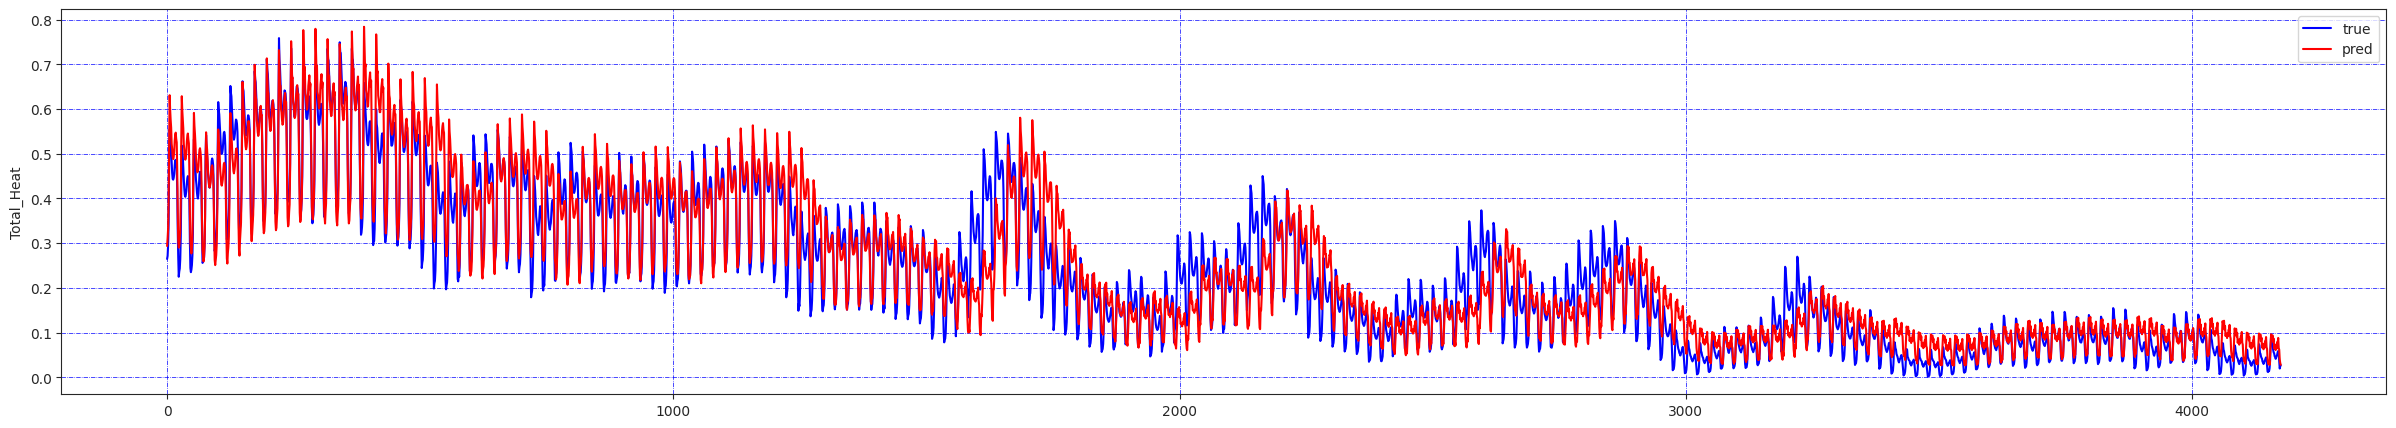

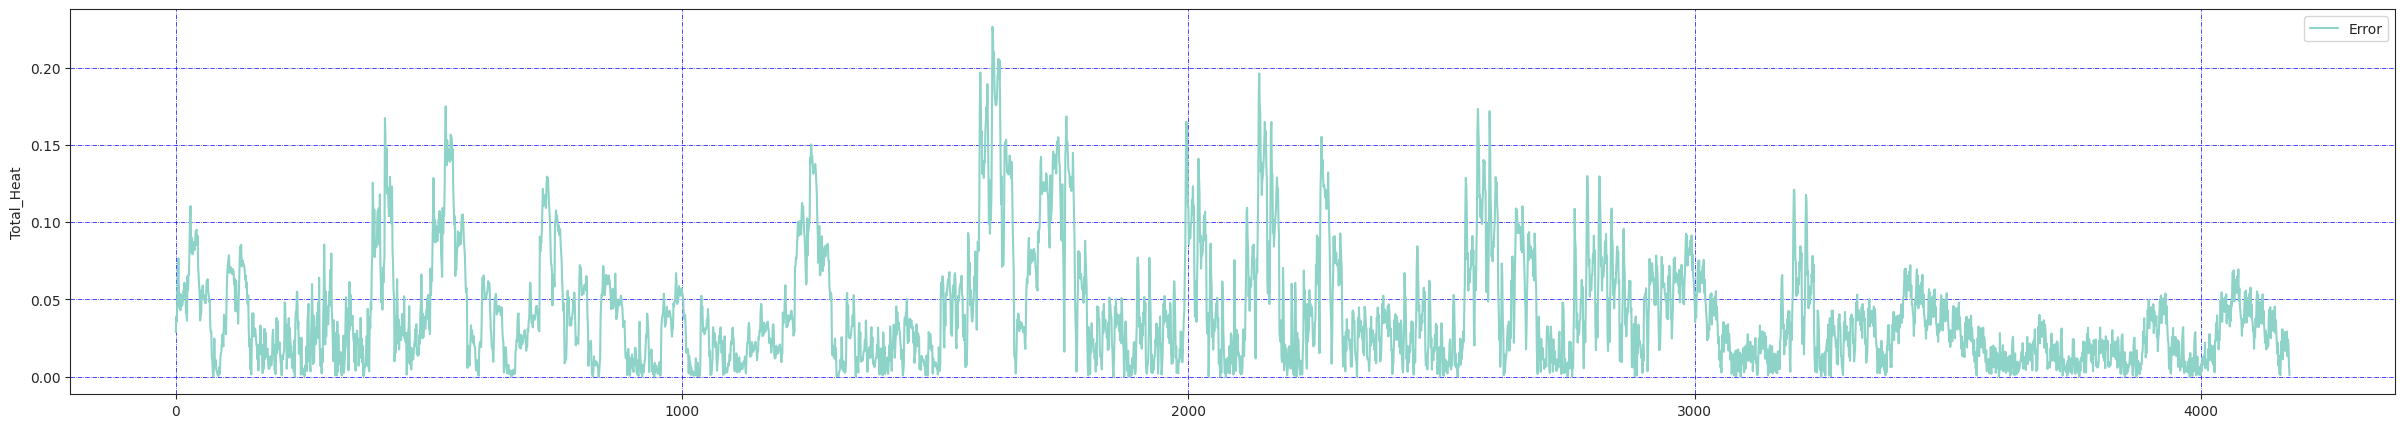

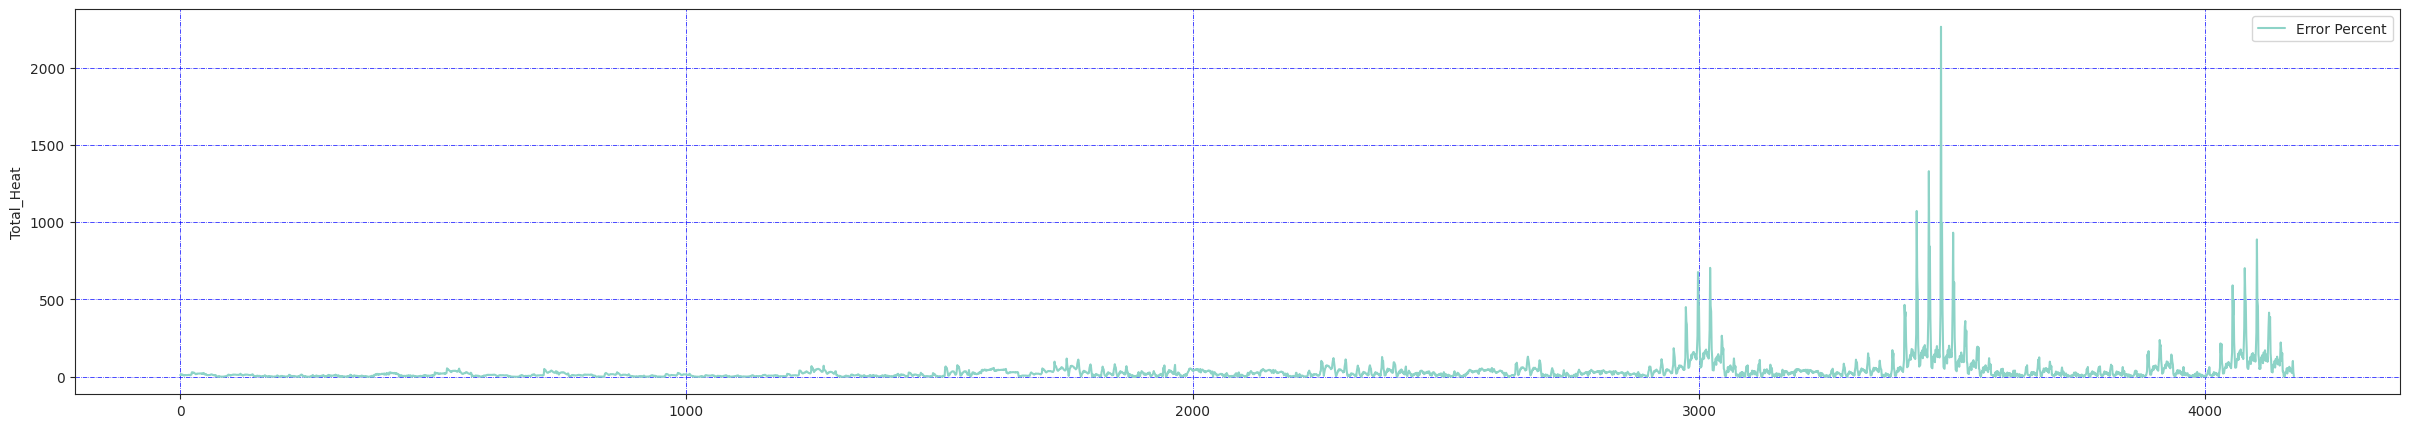

In [86]:
swarmup_steps = 0
start_idx = 10
pred_steps = x_test.shape[0]//2

with tf.device('/device:GPU:0'):
        mape = tf.keras.losses.MeanAbsolutePercentageError()
        
        sequence_length = sequence_length

        Y_true = []
        Y_pred = []
        MSE = []
        MAPE = []
        for i in tqdm_notebook(range(pred_steps), desc='Loop 1'):
                x = x_test[i].reshape(1,-1,1)
                y_true = y_test[i].reshape(-1,1)
                y_pred = Heat_model.predict(x, verbose=0).reshape(-1,1)

                Y_true.append(y_true[-24:])
                Y_pred.append(y_pred[-24:])
                MSE.append(tf.reduce_mean(tf.keras.losses.mean_squared_error(y_true,y_pred)))
                MAPE.append(tf.reduce_mean(tf.keras.losses.MAPE(y_true,y_pred)))

        y_true = np.array(Y_true).reshape(-1,1)
        y_pred = np.array(Y_pred).reshape(-1,1)
        # y_true = y_scaler.inverse_transform(y_true[:,:])   
        # y_pred = y_scaler.inverse_transform(y_pred[:,:])
        
print('MSE_mean:', tf.reduce_mean(MSE).numpy())
print('MAPE_mean:', tf.reduce_mean(MAPE).numpy())

for signal_ in tqdm_notebook(range(len(target_names)), desc='Loop 1'):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred[:, signal_]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal_]
        
        error = np.zeros(len(signal_true))
        p_error = np.zeros(len(signal_true))

        for i in range(len(signal_true)):
            # error[i] = signal_true[i]-signal_pred[i]
            error[i] = tf.keras.losses.MAE(signal_true[i][np.newaxis],signal_pred[i][np.newaxis])
            p_error[i] = tf.keras.losses.MAPE(signal_true[i][np.newaxis],signal_pred[i][np.newaxis])


        # Make the plotting-canvas bigger.
        plt.figure(figsize=(30,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, color='b', label='true')
        plt.plot(signal_pred, color='r', label='pred')

        
        # Plot labels etc.
        plt.ylabel(target_names[signal_])
        plt.grid(color='b', linestyle='-.', linewidth=0.5)
        plt.legend()
        plt.show()
        
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(30,5))
        
        # Plot and compare the two signals.
        plt.plot(error, label='Error')

        # Plot labels etc.
        plt.ylabel(target_names[signal_])
        plt.grid(color='b', linestyle='-.', linewidth=0.5)
        plt.legend()
        plt.show()

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(30,5))
        
        # Plot and compare the two signals.
        plt.plot(p_error, label='Error Percent')        
                

        # Plot labels etc.
        plt.ylabel(target_names[signal_])
        plt.grid(color='b', linestyle='-.', linewidth=0.5)
        plt.legend()
        plt.show()